# Nordeus Data Science Challenge
This problem can be approached as both a classification and a regression task. However, I found it more appropriate to treat it as a regression problem, as the target values are numerical and not entirely independent categories. I experimented with classifiers as well, but they produced less accurate results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# Exploring data

In [2]:
lives = pd.read_csv("data/previous_lives_training_data.csv", parse_dates=["registration_date"])
lives.head()

user_id registration_date  registration_season_day registration_country  \
0        5        2022-04-21                       26               France   
1        5        2023-05-07                       15               France   
2        7        2022-04-06                       11               Turkey   
3        7        2023-02-06                        9               Turkey   
4        7        2023-05-28                        8               Turkey   

  registration_channel_detailed registration_store  \
0                       Organic           AppStore   
1                          Paid           AppStore   
2                       Organic           AppStore   
3                       Organic         GooglePlay   
4                       Unknown         GooglePlay   

  registration_platform_specific  is_payer_lifetime  days_active_lifetime  \
0                      iOS Phone              False                     1   
1                      iOS Phone              False                    18   
2                      iOS Phone              False                    21   
3                  Android Phone              False                     2   
4                  Android Phone              False                     1   

   transaction_count_iap_lifetime  is_rewarded_video_watcher_lifetime  
0                               0                               False  
1                               0                                True  
2                               0                                True  
3                               0                               False  
4                               0                               False

In [3]:
lives.isna().sum(), lives.dtypes, lives.shape

(user_id                               0
 registration_date                     0
 registration_season_day               0
 registration_country                  0
 registration_channel_detailed         0
 registration_store                    0
 registration_platform_specific        0
 is_payer_lifetime                     0
 days_active_lifetime                  0
 transaction_count_iap_lifetime        0
 is_rewarded_video_watcher_lifetime    0
 dtype: int64,
 user_id                                        int64
 registration_date                     datetime64[ns]
 registration_season_day                        int64
 registration_country                          object
 registration_channel_detailed                 object
 registration_store                            object
 registration_platform_specific                object
 is_payer_lifetime                               bool
 days_active_lifetime                           int64
 transaction_count_iap_lifetime                 

### Correlation matrix of lives dataframe

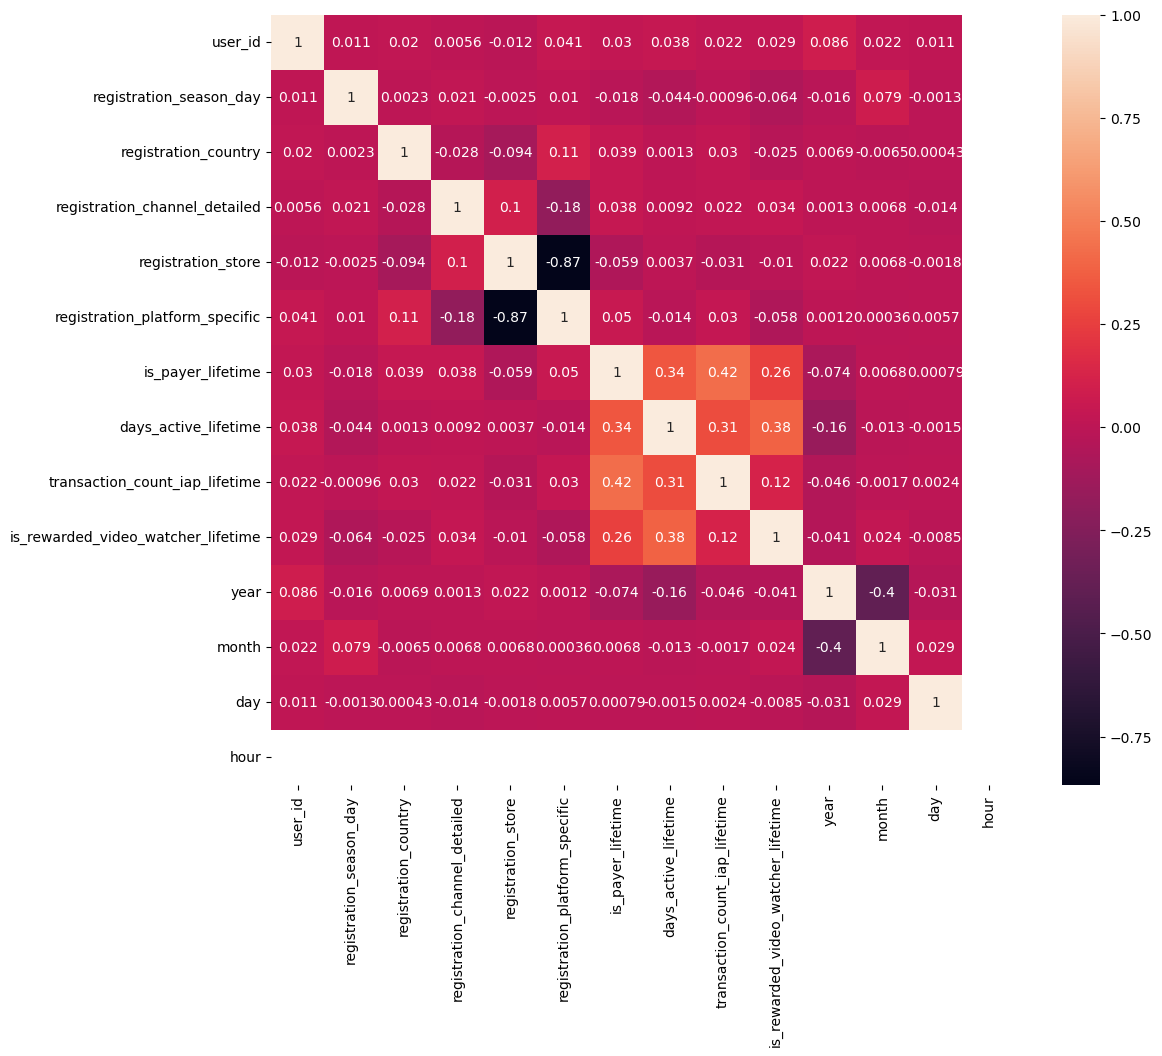

In [4]:
df_numeric = lives.copy()
df_numeric['year'] = df_numeric['registration_date'].dt.year
df_numeric['month'] = df_numeric['registration_date'].dt.month
df_numeric['day'] = df_numeric['registration_date'].dt.day
df_numeric['hour'] = df_numeric['registration_date'].dt.hour
df_numeric.drop("registration_date", axis=1, inplace=True)
for col in df_numeric.select_dtypes(include='object').columns:
    df_numeric[col] = df_numeric[col].astype('category').cat.codes
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(12, 10))
sns.heatmap(df_numeric.corr(), annot=True)
plt.show()

In [5]:
reg = pd.read_csv("data/registration_data_training.csv", parse_dates=["registration_time_utc"])
reg.head()

user_id registration_time_utc registration_platform_specific  \
0        5   2024-05-25 01:26:48                      iOS Phone   
1        7   2024-06-14 20:09:31                  Android Phone   
2       13   2024-05-31 09:06:51                  Android Phone   
3       23   2024-05-31 04:00:33                  Android Phone   
4       25   2024-06-15 19:56:05                      iOS Phone   

  registration_country registration_store  registration_season_day  \
0               France           AppStore                        7   
1               Turkey         GooglePlay                       27   
2              Belarus         GooglePlay                       13   
3            Indonesia         GooglePlay                       13   
4                Egypt           AppStore                       28   

  registration_channel_detailed registration_device_type  \
0                       Organic                    Phone   
1                       Unknown                    Phone   
2                       Organic                    Phone   
3                          Paid                    Phone   
4                       Organic                    Phone   

  registration_device_manufacturer  session_count  ...  rests_stash  \
0                            Apple              1  ...          524   
1                           Xiaomi              1  ...          962   
2                           Xiaomi              2  ...          829   
3                             OPPO              4  ...          180   
4                            Apple              5  ...          209   

   rests_spent  treatments_spent  morale_spent  money_stash  \
0            0                 0             0   1066076772   
1            0                 0             0   1224446429   
2            0                 0             0   1221792142   
3           39                12             9    928112709   
4           80                 0             2    326553498   

   avg_stars_top_11_players  avg_stars_top_3_players  avg_age_top_11_players  \
0                  4.721867                 5.451511                    22.0   
1                  4.911067                 5.303822                    22.0   
2                  5.018146                 5.746889                    24.0   
3                  5.827455                 6.692578                    22.0   
4                  5.340412                 5.775289                    24.0   

   training_count  days_active_first_28_days_after_registration  
0               0                                             0  
1               1                                             0  
2               3                                             0  
3               7                                             1  
4               6                                             3  

[5 rows x 30 columns]

### Distribution of target variable values:

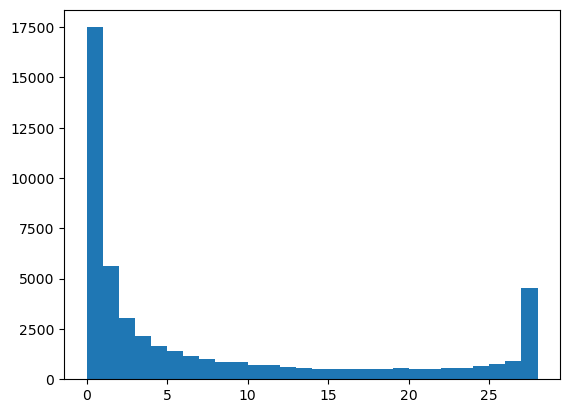

In [6]:
plt.hist(reg.days_active_first_28_days_after_registration, np.arange(0, 29))
plt.show()

In [7]:
reg.isna().sum()

user_id                                            0
registration_time_utc                              0
registration_platform_specific                     0
registration_country                               0
registration_store                                 0
registration_season_day                            0
registration_channel_detailed                      0
registration_device_type                           0
registration_device_manufacturer                1813
session_count                                      0
playtime                                           0
number_of_devices_used                             0
total_match_played_count                           0
total_match_won_count                              0
total_match_watched_count                          0
transaction_count_iap                              0
transaction_count_rewarded_video                   0
tokens_spent                                       0
tokens_stash                                  

In [8]:
reg.fillna({"registration_device_manufacturer":"Unknown", "avg_age_top_11_players":reg.avg_age_top_11_players.median()}, inplace=True)

In [9]:
lives_test = pd.read_csv("data/previous_lives_test_data.csv", parse_dates=["registration_date"])
lives_test.head()

user_id registration_date  registration_season_day registration_country  \
0   300004        2022-04-20                       25          Switzerland   
1   300004        2023-04-06                       12              Finland   
2   300006        2022-06-09                       19               Brazil   
3   300012        2022-05-25                        4          Switzerland   
4   300012        2023-06-13                       24          Switzerland   

  registration_channel_detailed registration_store  \
0                       Organic         GooglePlay   
1                          Paid         GooglePlay   
2                       Organic           AppStore   
3                          Paid         GooglePlay   
4                          Paid         GooglePlay   

  registration_platform_specific  is_payer_lifetime  days_active_lifetime  \
0                  Android Phone              False                     5   
1                  Android Phone              False                     1   
2                      iOS Phone              False                    69   
3                  Android Phone              False                     4   
4                  Android Phone              False                    96   

   transaction_count_iap_lifetime  is_rewarded_video_watcher_lifetime  
0                               0                                True  
1                               0                               False  
2                               0                                True  
3                               0                               False  
4                               0                                True

In [10]:
lives_test.isna().sum()

user_id                               0
registration_date                     0
registration_season_day               0
registration_country                  0
registration_channel_detailed         0
registration_store                    0
registration_platform_specific        0
is_payer_lifetime                     0
days_active_lifetime                  0
transaction_count_iap_lifetime        0
is_rewarded_video_watcher_lifetime    0
dtype: int64

In [11]:
reg_test = pd.read_csv("data/registration_data_test.csv", parse_dates=["registration_time_utc"])
reg_test.head()

user_id registration_time_utc registration_platform_specific  \
0   300004   2024-07-04 10:16:58                  Android Phone   
1   300006   2024-06-25 23:04:49                      iOS Phone   
2   300012   2024-06-17 17:12:37                  Android Phone   
3   300022   2024-06-24 15:29:55                  Android Phone   
4   300031   2024-06-30 16:09:40                  Android Phone   

  registration_country registration_store  registration_season_day  \
0              Hungary         GooglePlay                       19   
1               Brazil           AppStore                       10   
2          Switzerland         GooglePlay                        2   
3            Indonesia         GooglePlay                        9   
4            Indonesia         GooglePlay                       15   

  registration_channel_detailed registration_device_type  \
0                          Paid                    Phone   
1                       Organic                    Phone   
2                          Paid                    Phone   
3                       Organic                    Phone   
4                       Organic                    Phone   

  registration_device_manufacturer  session_count  ...  tokens_bought  \
0                           Xiaomi              8  ...              0   
1                            Apple              1  ...              0   
2                             OPPO              1  ...              0   
3                          samsung              1  ...              0   
4                          samsung              1  ...              0   

   rests_stash  rests_spent  treatments_spent  morale_spent  money_stash  \
0          910          122                 0            22    947426140   
1          340            6                 0             0    706985337   
2          683            0                 0             0   1102920908   
3          555            0                 0             0    976796944   
4          556            4                 0             0   1049312573   

   avg_stars_top_11_players  avg_stars_top_3_players  avg_age_top_11_players  \
0                  5.484873                 6.110755                    21.0   
1                  5.202279                 5.986044                    24.0   
2                  4.911588                 5.371822                    22.0   
3                  5.322267                 5.837511                    23.0   
4                  5.720764                 6.415555                    23.0   

   training_count  
0               5  
1               3  
2               1  
3               0  
4               3  

[5 rows x 29 columns]

In [12]:
reg_test.isna().sum()

user_id                                0
registration_time_utc                  0
registration_platform_specific         0
registration_country                   0
registration_store                     0
registration_season_day                0
registration_channel_detailed          0
registration_device_type               0
registration_device_manufacturer    1659
session_count                          0
playtime                               0
number_of_devices_used                 0
total_match_played_count               0
total_match_won_count                  0
total_match_watched_count              0
transaction_count_iap                  0
transaction_count_rewarded_video       0
tokens_spent                           0
tokens_stash                           0
tokens_bought                          0
rests_stash                            0
rests_spent                            0
treatments_spent                       0
morale_spent                           0
money_stash     

In [13]:
reg_test.fillna({"registration_device_manufacturer":"Unknown", "avg_age_top_11_players":reg.avg_age_top_11_players.median()}, inplace=True)

In [14]:
lives.shape, reg.shape, lives_test.shape, reg_test.shape

((84941, 11), (50000, 30), (86113, 11), (50000, 29))

# Merging dataframes

In [15]:
reg.user_id.isin(lives.user_id).sum()

50000

In [16]:
df = pd.merge(reg, lives, on='user_id', how='left')
df

user_id registration_time_utc registration_platform_specific_x  \
0            5   2024-05-25 01:26:48                        iOS Phone   
1            5   2024-05-25 01:26:48                        iOS Phone   
2            7   2024-06-14 20:09:31                    Android Phone   
3            7   2024-06-14 20:09:31                    Android Phone   
4            7   2024-06-14 20:09:31                    Android Phone   
...        ...                   ...                              ...   
84936   218949   2024-05-27 01:57:37                    Android Phone   
84937   218956   2024-06-03 15:25:35                    Android Phone   
84938   218956   2024-06-03 15:25:35                    Android Phone   
84939   218956   2024-06-03 15:25:35                    Android Phone   
84940   218956   2024-06-03 15:25:35                    Android Phone   

      registration_country_x registration_store_x  registration_season_day_x  \
0                     France             AppStore                          7   
1                     France             AppStore                          7   
2                     Turkey           GooglePlay                         27   
3                     Turkey           GooglePlay                         27   
4                     Turkey           GooglePlay                         27   
...                      ...                  ...                        ...   
84936              Indonesia           GooglePlay                          9   
84937              Indonesia           GooglePlay                         16   
84938              Indonesia           GooglePlay                         16   
84939              Indonesia           GooglePlay                         16   
84940              Indonesia           GooglePlay                         16   

      registration_channel_detailed_x registration_device_type  \
0                             Organic                    Phone   
1                             Organic                    Phone   
2                             Unknown                    Phone   
3                             Unknown                    Phone   
4                             Unknown                    Phone   
...                               ...                      ...   
84936                            Paid                    Phone   
84937                            Paid                    Phone   
84938                            Paid                    Phone   
84939                            Paid                    Phone   
84940                            Paid                    Phone   

      registration_device_manufacturer  session_count  ...  registration_date  \
0                                Apple              1  ...         2022-04-21   
1                                Apple              1  ...         2023-05-07   
2                               Xiaomi              1  ...         2022-04-06   
3                               Xiaomi              1  ...         2023-02-06   
4                               Xiaomi              1  ...         2023-05-28   
...                                ...            ...  ...                ...   
84936                           realme              3  ...         2022-10-15   
84937                             OPPO              1  ...         2022-04-18   
84938                             OPPO              1  ...         2023-02-06   
84939                             OPPO              1  ...         2023-07-08   
84940                             OPPO              1  ...         2024-02-14   

       registration_season_day_y  registration_country_y  \
0                             26                  France   
1                             15                  France   
2                             11                  Turkey   
3                              9                  Turkey   
4                              8                  Turkey   
...                          ...           

In [17]:
df.isna().sum()

user_id                                         0
registration_time_utc                           0
registration_platform_specific_x                0
registration_country_x                          0
registration_store_x                            0
registration_season_day_x                       0
registration_channel_detailed_x                 0
registration_device_type                        0
registration_device_manufacturer                0
session_count                                   0
playtime                                        0
number_of_devices_used                          0
total_match_played_count                        0
total_match_won_count                           0
total_match_watched_count                       0
transaction_count_iap                           0
transaction_count_rewarded_video                0
tokens_spent                                    0
tokens_stash                                    0
tokens_bought                                   0


In [18]:
reg.columns, lives.columns

(Index(['user_id', 'registration_time_utc', 'registration_platform_specific',
        'registration_country', 'registration_store', 'registration_season_day',
        'registration_channel_detailed', 'registration_device_type',
        'registration_device_manufacturer', 'session_count', 'playtime',
        'number_of_devices_used', 'total_match_played_count',
        'total_match_won_count', 'total_match_watched_count',
        'transaction_count_iap', 'transaction_count_rewarded_video',
        'tokens_spent', 'tokens_stash', 'tokens_bought', 'rests_stash',
        'rests_spent', 'treatments_spent', 'morale_spent', 'money_stash',
        'avg_stars_top_11_players', 'avg_stars_top_3_players',
        'avg_age_top_11_players', 'training_count',
        'days_active_first_28_days_after_registration'],
       dtype='object'),
 Index(['user_id', 'registration_date', 'registration_season_day',
        'registration_country', 'registration_channel_detailed',
        'registration_store', 'r

In [19]:
df.user_id.value_counts()

user_id
201487    7
61093     7
94566     7
12008     6
10899     6
         ..
139216    1
39577     1
139209    1
39580     1
31673     1
Name: count, Length: 50000, dtype: int64

In [20]:
df[df['user_id']==201487].T

77842  \
user_id                                                    201487   
registration_time_utc                         2024-05-20 11:21:55   
registration_platform_specific_x                    Android Phone   
registration_country_x                                     Poland   
registration_store_x                                   GooglePlay   
registration_season_day_x                                       2   
registration_channel_detailed_x                           Organic   
registration_device_type                                    Phone   
registration_device_manufacturer                           Xiaomi   
session_count                                                   1   
playtime                                                   165073   
number_of_devices_used                                          1   
total_match_played_count                                        0   
total_match_won_count                                           0   
total_match_watched_count                                       0   
transaction_count_iap                                           0   
transaction_count_rewarded_video                                0   
tokens_spent                                                    0   
tokens_stash                                                   91   
tokens_bought                                                   0   
rests_stash                                                  1030   
rests_spent                                                     0   
treatments_spent                                                0   
morale_spent                                                    0   
money_stash                                            1242731475   
avg_stars_top_11_players                                 4.848897   
avg_stars_top_3_players                                  5.353422   
avg_age_top_11_players                                       24.0   
training_count                                                  1   
days_active_first_28_days_after_registration                    0   
registration_date                             2022-04-02 00:00:00   
registration_season_day_y                                       7   
registration_country_y                                     Poland   
registration_channel_detailed_y                           Organic   
registration_store_y                                   GooglePlay   
registration_platform_specific_y                    Android Phone   
is_payer_lifetime                                           False   
days_active_lifetime                                            1   
transaction_count_iap_lifetime                                  0   
is_rewarded_video_watcher_lifetime                          False   

                                                            77843  \
user_id                                                    201487   
registration_time_utc                         2024-05-20 11:21:55   
registration_platform_specific_x                    Android Phone   
registration_country_x                                     Poland   
registration_store_x                                   GooglePlay   
registration_season_day_x                                       2   
registration_channel_detailed_x                           Organic   
registration_device_type                                    Phone   
registration_device_manufacturer                           Xiaomi   
session_count                                                   1   
playtime                                                   165073   
number_of_devices_used                                          1   
total_match_played_count                                        0   
total_match_won_count                                           0   
total_match_watched_count                                       0   
transaction_count_iap                                           0   
transaction_count_rewarded_video                         

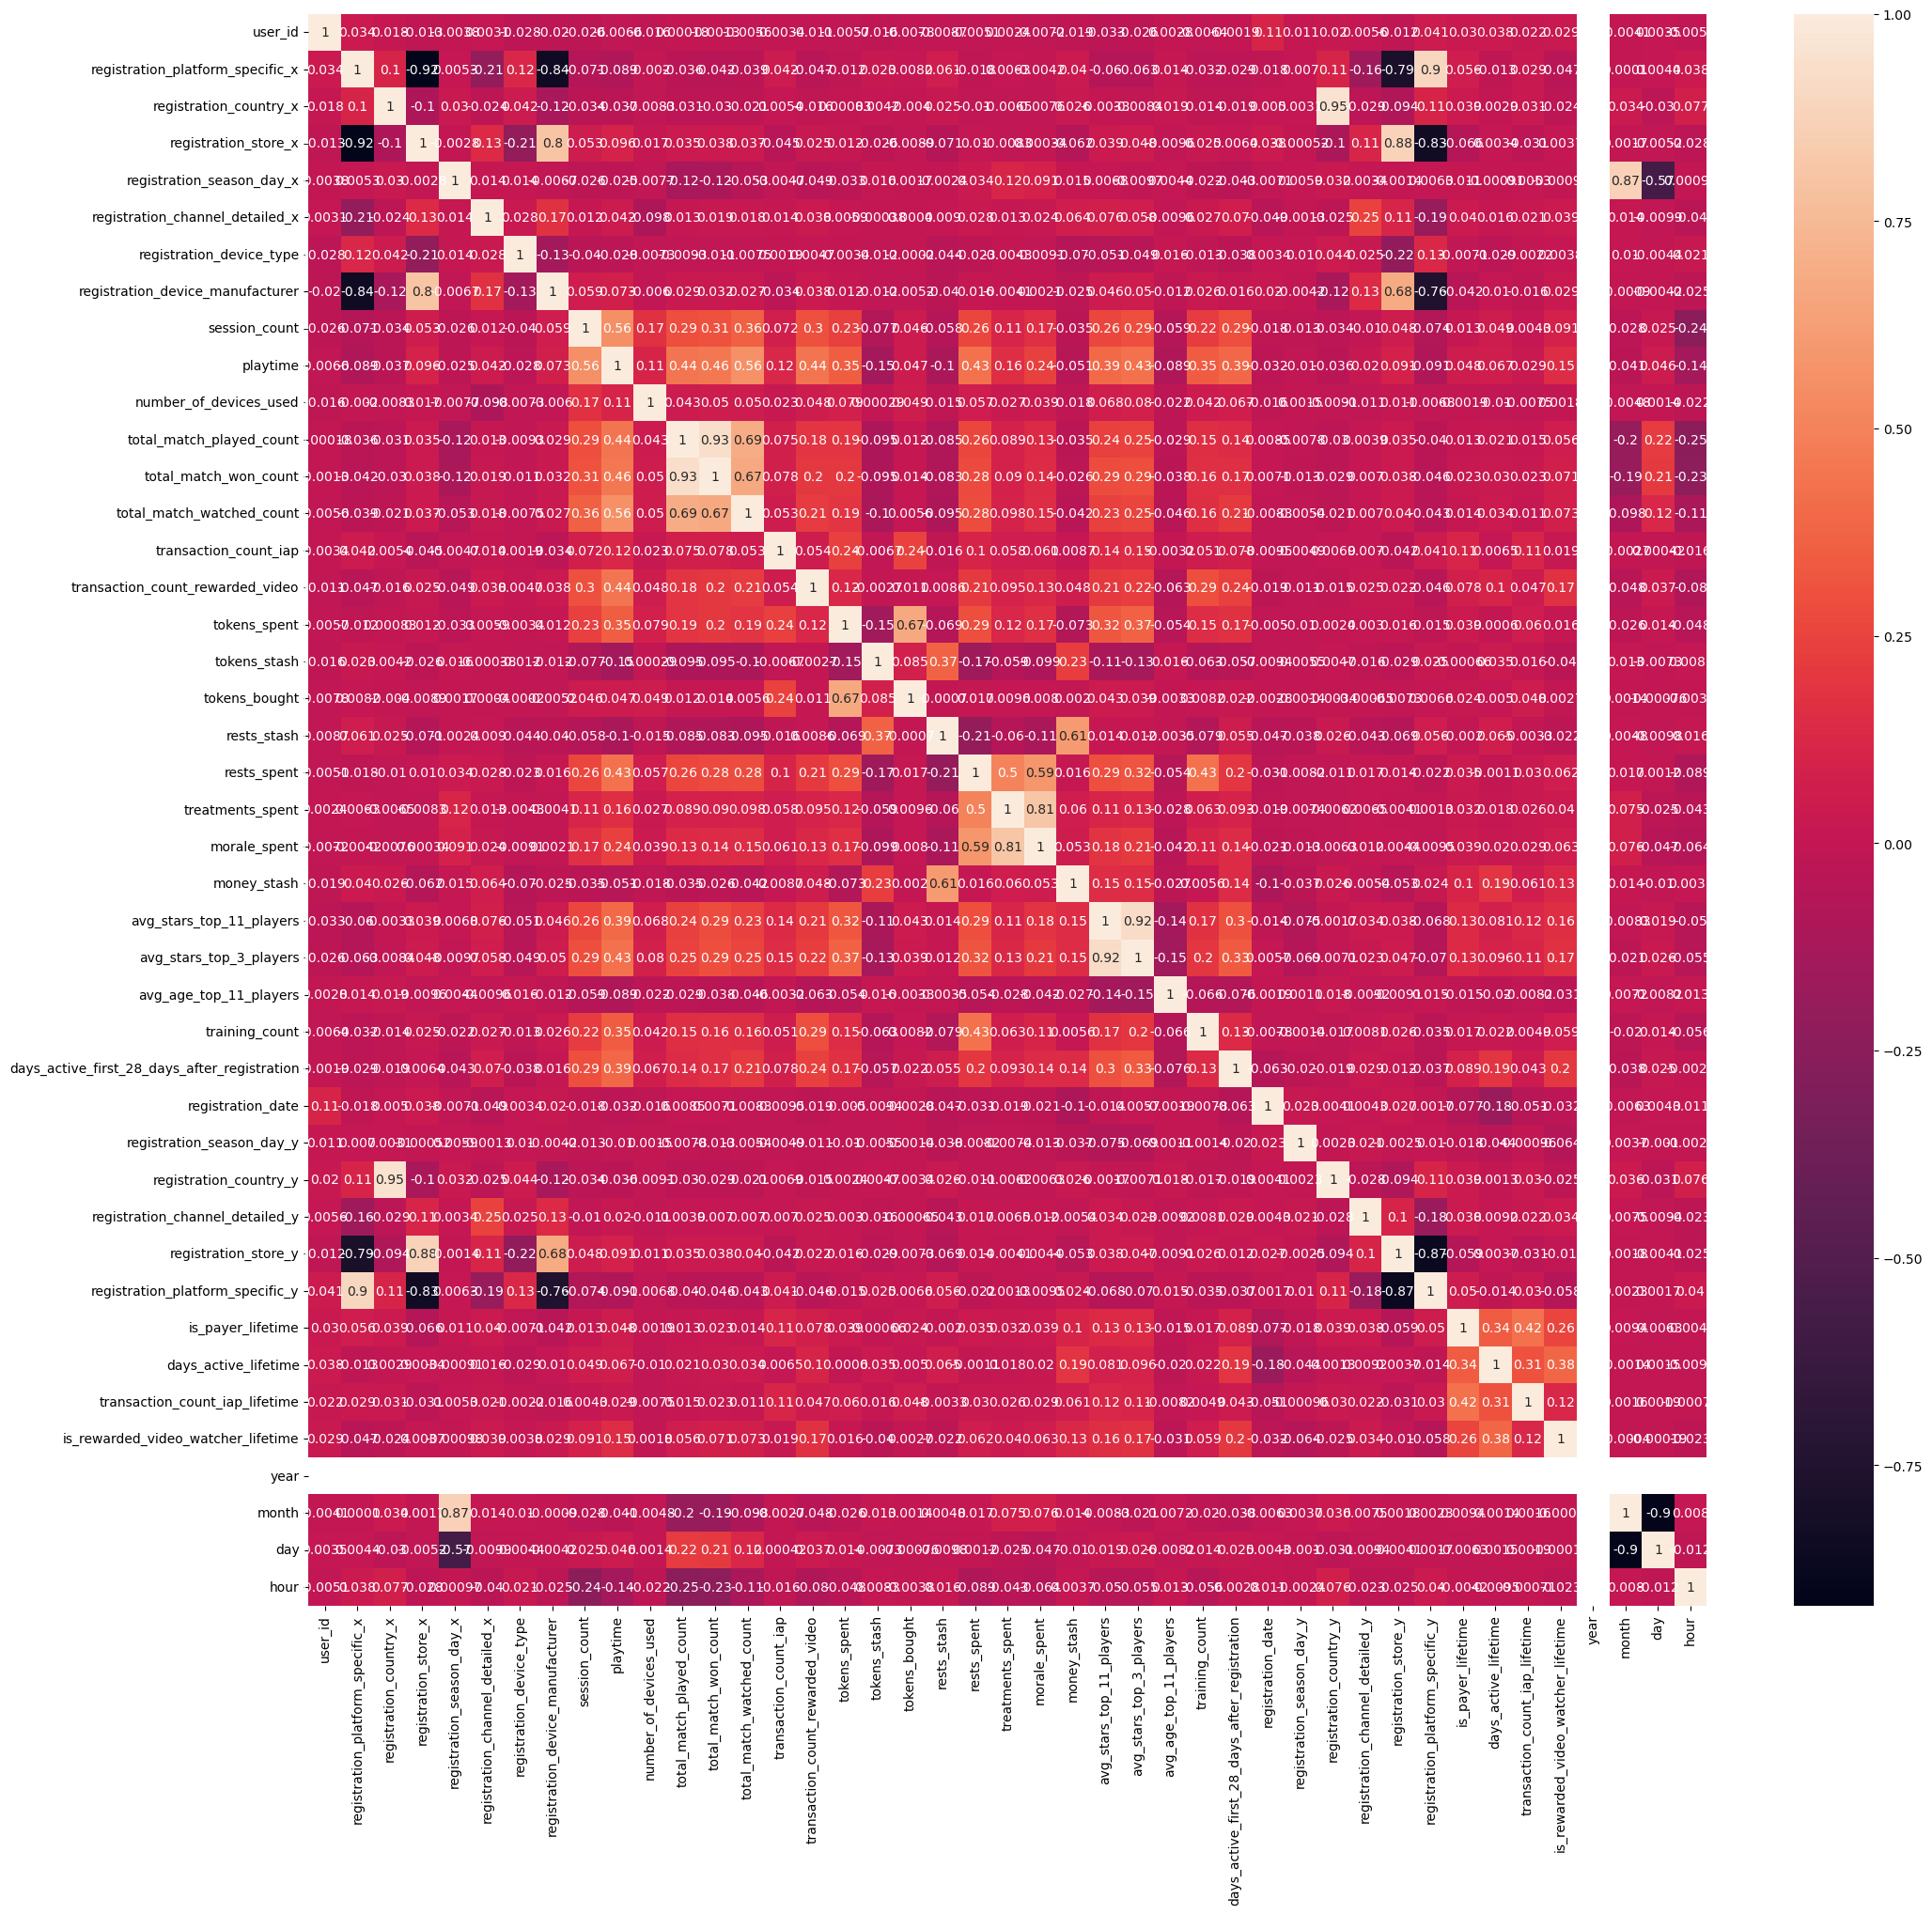

In [21]:
df_numeric3 = df.copy()
df_numeric3['year'] = df_numeric3['registration_time_utc'].dt.year
df_numeric3['month'] = df_numeric3['registration_time_utc'].dt.month
df_numeric3['day'] = df_numeric3['registration_time_utc'].dt.day
df_numeric3['hour'] = df_numeric3['registration_time_utc'].dt.hour
df_numeric3.drop("registration_time_utc", axis=1, inplace=True)
for col in df_numeric3.select_dtypes(include='object').columns:
    df_numeric3[col] = df_numeric3[col].astype('category').cat.codes
df_numeric3 = df_numeric3.apply(pd.to_numeric, errors='coerce')
fig = plt.figure(figsize=(24, 22))
sns.heatmap(df_numeric3.corr(), annot=True)
fig.savefig('correlation_matrix.png')
plt.show()

In [23]:
def group_data(df):
    df.drop("registration_season_day_y", axis=1, inplace = True, errors='ignore')
    df.drop("registration_country_y", axis=1, inplace = True, errors='ignore')
    df.drop("registration_channel_detailed_y", axis=1, inplace = True, errors='ignore')
    df.drop("registration_store_y", axis=1, inplace = True, errors='ignore')
    df.drop("registration_platform_specific_y", axis=1, inplace = True, errors='ignore')
    
    df = df.groupby(['user_id', 'registration_time_utc', 'registration_platform_specific_x',
       'registration_country_x', 'registration_store_x', 'registration_season_day_x',
       'registration_channel_detailed_x', 'registration_device_type',
       'registration_device_manufacturer', 'session_count', 'playtime',
       'number_of_devices_used', 'total_match_played_count',
       'total_match_won_count', 'total_match_watched_count',
       'transaction_count_iap', 'transaction_count_rewarded_video',
       'tokens_spent', 'tokens_stash', 'tokens_bought', 'rests_stash',
       'rests_spent', 'treatments_spent', 'morale_spent', 'money_stash',
       'avg_stars_top_11_players', 'avg_stars_top_3_players',
       'avg_age_top_11_players', 'training_count',
       'days_active_first_28_days_after_registration']).agg(
                        first_registration_year = ('registration_date', 'first'),
                        past_lives_count=('registration_date','count'), 
                        is_payer_lifetime = ('is_payer_lifetime','any'),
                        is_payer_last_time = ('is_payer_lifetime', 'last'),
                        days_active_last = ('days_active_lifetime','last'),
                        days_active_max = ('days_active_lifetime','max'),
                        transaction_count_iap_lifetime_sum = ('transaction_count_iap_lifetime','sum'),
                        transaction_count_iap_lifetime_last = ('transaction_count_iap_lifetime','last'),
                        is_rewarded_video_watcher_lifetime = ('is_rewarded_video_watcher_lifetime','sum')
                         ).reset_index()
    return df



In [24]:
df = group_data(df)
df[df['user_id']==201487].T

46035
user_id                                                    201487
registration_time_utc                         2024-05-20 11:21:55
registration_platform_specific_x                    Android Phone
registration_country_x                                     Poland
registration_store_x                                   GooglePlay
registration_season_day_x                                       2
registration_channel_detailed_x                           Organic
registration_device_type                                    Phone
registration_device_manufacturer                           Xiaomi
session_count                                                   1
playtime                                                   165073
number_of_devices_used                                          1
total_match_played_count                                        0
total_match_won_count                                           0
total_match_watched_count                                       0
transaction_count_iap                                           0
transaction_count_rewarded_video                                0
tokens_spent                                                    0
tokens_stash                                                   91
tokens_bought                                                   0
rests_stash                                                  1030
rests_spent                                                     0
treatments_spent                                                0
morale_spent                                                    0
money_stash                                            1242731475
avg_stars_top_11_players                                 4.848897
avg_stars_top_3_players                                  5.353422
avg_age_top_11_players                                       24.0
training_count                                                  1
days_active_first_28_days_after_registration                    0
first_registration_year                       2022-04-02 00:00:00
past_lives_count                                                7
is_payer_lifetime                                            True
is_payer_last_time                                          False
days_active_last                                                2
days_active_max                                                38
transaction_count_iap_lifetime_sum                             11
transaction_count_iap_lifetime_last                             0
is_rewarded_video_watcher_lifetime                              1

In [25]:
df.head()

user_id registration_time_utc registration_platform_specific_x  \
0        5   2024-05-25 01:26:48                        iOS Phone   
1        7   2024-06-14 20:09:31                    Android Phone   
2       13   2024-05-31 09:06:51                    Android Phone   
3       23   2024-05-31 04:00:33                    Android Phone   
4       25   2024-06-15 19:56:05                        iOS Phone   

  registration_country_x registration_store_x  registration_season_day_x  \
0                 France             AppStore                          7   
1                 Turkey           GooglePlay                         27   
2                Belarus           GooglePlay                         13   
3              Indonesia           GooglePlay                         13   
4                  Egypt             AppStore                         28   

  registration_channel_detailed_x registration_device_type  \
0                         Organic                    Phone   
1                         Unknown                    Phone   
2                         Organic                    Phone   
3                            Paid                    Phone   
4                         Organic                    Phone   

  registration_device_manufacturer  session_count  ...  \
0                            Apple              1  ...   
1                           Xiaomi              1  ...   
2                           Xiaomi              2  ...   
3                             OPPO              4  ...   
4                            Apple              5  ...   

   days_active_first_28_days_after_registration  first_registration_year  \
0                                             0               2022-04-21   
1                                             0               2022-04-06   
2                                             0               2022-10-18   
3                                             1               2023-08-30   
4                                             3               2022-08-24   

   past_lives_count  is_payer_lifetime  is_payer_last_time  days_active_last  \
0                 2              False               False                18   
1                 3              False               False                 1   
2                 2              False               False                 1   
3                 1              False               False                 2   
4                 2              False               False                 1   

   days_active_max  transaction_count_iap_lifetime_sum  \
0               18                                   0   
1               21                                   0   
2              221                                   0   
3                2                                   0   
4               18                                   0   

   transaction_count_iap_lifetime_last  is_rewarded_video_watcher_lifetime  
0                                    0                                   1  
1                                    0                                   1  
2                                    0                                   1  
3                                    0                                   1  
4                                    0                                   1  

[5 rows x 39 columns]

In [26]:
df_test = pd.merge(reg_test, lives_test, on='user_id', how='left')
df_test

user_id registration_time_utc registration_platform_specific_x  \
0       300004   2024-07-04 10:16:58                    Android Phone   
1       300004   2024-07-04 10:16:58                    Android Phone   
2       300006   2024-06-25 23:04:49                        iOS Phone   
3       300012   2024-06-17 17:12:37                    Android Phone   
4       300012   2024-06-17 17:12:37                    Android Phone   
...        ...                   ...                              ...   
86108   512712   2024-06-30 13:36:51                    Android Phone   
86109   512712   2024-06-30 13:36:51                    Android Phone   
86110   512713   2024-06-29 07:40:23                    Android Phone   
86111   512713   2024-06-29 07:40:23                    Android Phone   
86112   512713   2024-06-29 07:40:23                    Android Phone   

      registration_country_x registration_store_x  registration_season_day_x  \
0                    Hungary           GooglePlay                         19   
1                    Hungary           GooglePlay                         19   
2                     Brazil             AppStore                         10   
3                Switzerland           GooglePlay                          2   
4                Switzerland           GooglePlay                          2   
...                      ...                  ...                        ...   
86108              Indonesia           GooglePlay                         15   
86109              Indonesia           GooglePlay                         15   
86110               Thailand           GooglePlay                         14   
86111               Thailand           GooglePlay                         14   
86112               Thailand           GooglePlay                         14   

      registration_channel_detailed_x registration_device_type  \
0                                Paid                    Phone   
1                                Paid                    Phone   
2                             Organic                    Phone   
3                                Paid                    Phone   
4                                Paid                    Phone   
...                               ...                      ...   
86108                         Organic                    Phone   
86109                         Organic                    Phone   
86110                            Paid                    Phone   
86111                            Paid                    Phone   
86112                            Paid                    Phone   

      registration_device_manufacturer  session_count  ...  registration_date  \
0                               Xiaomi              8  ...         2022-04-20   
1                               Xiaomi              8  ...         2023-04-06   
2                                Apple              1  ...         2022-06-09   
3                                 OPPO              1  ...         2022-05-25   
4                                 OPPO              1  ...         2023-06-13   
...                                ...            ...  ...                ...   
86108                           Xiaomi              2  ...         2022-05-19   
86109                           Xiaomi              2  ...         2024-01-09   
86110                          samsung              1  ...         2022-08-17   
86111                          samsung              1  ...         2023-02-14   
86112                          samsung              1  ...         2023-07-01   

       registration_season_day_y  registration_country_y  \
0                             25             Switzerland   
1                             12                 Finland   
2                             19                  Brazil   
3                              4             Switzerland   
4                             24             Switzerland   
...                          ...           

In [27]:
df_test.isna().sum()

user_id                               0
registration_time_utc                 0
registration_platform_specific_x      0
registration_country_x                0
registration_store_x                  0
registration_season_day_x             0
registration_channel_detailed_x       0
registration_device_type              0
registration_device_manufacturer      0
session_count                         0
playtime                              0
number_of_devices_used                0
total_match_played_count              0
total_match_won_count                 0
total_match_watched_count             0
transaction_count_iap                 0
transaction_count_rewarded_video      0
tokens_spent                          0
tokens_stash                          0
tokens_bought                         0
rests_stash                           0
rests_spent                           0
treatments_spent                      0
morale_spent                          0
money_stash                           0


In [28]:
df_test.user_id.value_counts()

user_id
356501    8
509881    7
510192    7
348801    7
357526    7
         ..
427970    1
427966    1
427965    1
427963    1
406899    1
Name: count, Length: 50000, dtype: int64

In [29]:
df_test[df_test['user_id']==356501].T

24426                24427  \
user_id                                          356501               356501   
registration_time_utc               2024-06-27 13:00:58  2024-06-27 13:00:58   
registration_platform_specific_x          Android Phone        Android Phone   
registration_country_x                            Spain                Spain   
registration_store_x                         GooglePlay           GooglePlay   
registration_season_day_x                            12                   12   
registration_channel_detailed_x                 Organic              Organic   
registration_device_type                          Phone                Phone   
registration_device_manufacturer                 Xiaomi               Xiaomi   
session_count                                         1                    1   
playtime                                          77881                77881   
number_of_devices_used                                1                    1   
total_match_played_count                              0                    0   
total_match_won_count                                 0                    0   
total_match_watched_count                             0                    0   
transaction_count_iap                                 0                    0   
transaction_count_rewarded_video                      0                    0   
tokens_spent                                          0                    0   
tokens_stash                                         81                   81   
tokens_bought                                         0                    0   
rests_stash                                         238                  238   
rests_spent                                           0                    0   
treatments_spent                                      0                    0   
morale_spent                                          0                    0   
money_stash                                   383941881            383941881   
avg_stars_top_11_players                       4.838194             4.838194   
avg_stars_top_3_players                        5.304933             5.304933   
avg_age_top_11_players                             24.0                 24.0   
training_count                                        0                    0   
registration_date                   2022-05-25 00:00:00  2022-07-14 00:00:00   
registration_season_day_y                             4                   26   
registration_country_y                            Spain                Spain   
registration_channel_detailed_y                 Organic                 Paid   
registration_store_y                         GooglePlay           GooglePlay   
registration_platform_specific_y          Android Phone        Android Phone   
is_payer_lifetime                                 False                False   
days_active_lifetime                                  1                    1   
transaction_count_iap_lifetime                        0                    0   
is_rewarded_video_watcher_lifetime                False                False   

                                                  24428                24429  \
user_id                                          356501               356501   
registration_time_utc               2024-06-27 13:00:58  2024-06-27 13:00:58   
registration_platform_specific_x          Android Phone        Android Phone   
registration_country_x                            Spain                Spain   
registration_store_x                         GooglePlay           GooglePlay   
registration_season_day_x                            12                   12   
registration_channel_detailed_x                 Organic              Organic   
registration_device_type                          Phone                Phone   
registration_device_manufacturer                 Xiaomi               Xiaomi   
session_count                                    

In [30]:
df_test["days_active_first_28_days_after_registration"] = -1
df_test = group_data(df_test)
df_test[df_test['user_id']==356501].T

13196
user_id                                                    356501
registration_time_utc                         2024-06-27 13:00:58
registration_platform_specific_x                    Android Phone
registration_country_x                                      Spain
registration_store_x                                   GooglePlay
registration_season_day_x                                      12
registration_channel_detailed_x                           Organic
registration_device_type                                    Phone
registration_device_manufacturer                           Xiaomi
session_count                                                   1
playtime                                                    77881
number_of_devices_used                                          1
total_match_played_count                                        0
total_match_won_count                                           0
total_match_watched_count                                       0
transaction_count_iap                                           0
transaction_count_rewarded_video                                0
tokens_spent                                                    0
tokens_stash                                                   81
tokens_bought                                                   0
rests_stash                                                   238
rests_spent                                                     0
treatments_spent                                                0
morale_spent                                                    0
money_stash                                             383941881
avg_stars_top_11_players                                 4.838194
avg_stars_top_3_players                                  5.304933
avg_age_top_11_players                                       24.0
training_count                                                  0
days_active_first_28_days_after_registration                   -1
first_registration_year                       2022-05-25 00:00:00
past_lives_count                                                8
is_payer_lifetime                                           False
is_payer_last_time                                          False
days_active_last                                                5
days_active_max                                                 6
transaction_count_iap_lifetime_sum                              0
transaction_count_iap_lifetime_last                             0
is_rewarded_video_watcher_lifetime                              1

In [31]:
df_test.shape, df_test.dtypes

((50000, 39),
 user_id                                                  int64
 registration_time_utc                           datetime64[ns]
 registration_platform_specific_x                        object
 registration_country_x                                  object
 registration_store_x                                    object
 registration_season_day_x                                int64
 registration_channel_detailed_x                         object
 registration_device_type                                object
 registration_device_manufacturer                        object
 session_count                                            int64
 playtime                                                 int64
 number_of_devices_used                                   int64
 total_match_played_count                                 int64
 total_match_won_count                                    int64
 total_match_watched_count                                int64
 transaction_count_iap    

### Concatenating the train and test sets to align categorical columns so that they map to the same category numbers in both sets

In [32]:
combined_df = pd.concat([df, df_test], axis=0)
combined_df.shape

(100000, 39)

In [33]:
def preprocess(df):
    df['year'] = df['registration_time_utc'].dt.year
    df['month'] = df['registration_time_utc'].dt.month
    df['day'] = df['registration_time_utc'].dt.day
    df['hour'] = df['registration_time_utc'].dt.hour
    df.drop("registration_time_utc", axis=1, inplace=True, errors="ignore")

    df.drop("registration_store_x", axis=1, inplace = True, errors='ignore')
    df["registration_country_x"] = df["registration_country_x"].astype('category').cat.codes
    df["registration_device_manufacturer"] = df["registration_device_manufacturer"].astype('category').cat.codes
    df["registration_platform_specific_x"] = df["registration_platform_specific_x"].astype('category').cat.codes

    df["registration_channel_detailed_x"] = df["registration_channel_detailed_x"].astype('category').cat.codes
    df["registration_device_type"] = df["registration_device_type"].astype('category').cat.codes

    df["first_registration_year"] = df.first_registration_year.dt.year

    return df

In [34]:
combined_transformed = preprocess(combined_df)
combined_transformed

user_id  registration_platform_specific_x  registration_country_x  \
0            5                                 5                      63   
1            7                                 0                     183   
2           13                                 0                      17   
3           23                                 0                      86   
4           25                                 5                      55   
...        ...                               ...                     ...   
49995   512688                                 0                     114   
49996   512690                                 0                     114   
49997   512702                                 0                      86   
49998   512712                                 0                      86   
49999   512713                                 0                     178   

       registration_season_day_x  registration_channel_detailed_x  \
0                              7                                0   
1                             27                                2   
2                             13                                0   
3                             13                                1   
4                             28                                0   
...                          ...                              ...   
49995                          9                                0   
49996                          5                                1   
49997                          3                                1   
49998                         15                                0   
49999                         14                                1   

       registration_device_type  registration_device_manufacturer  \
0                             1                                19   
1                             1                               202   
2                             1                               202   
3                             1                               125   
4                             1                                19   
...                         ...                               ...   
49995                         1                               202   
49996                         1                               234   
49997                         1                               125   
49998                         1                               202   
49999                         1                               234   

       session_count  playtime  number_of_devices_used  ...  \
0                  1    141062                       1  ...   
1                  1    521754                       1  ...   
2                  2   1703183                       1  ...   
3                  4   3181700                       1  ...   
4                  5   5866921                       1  ...   
...              ...       ...                     ...  ...   
49995              3   1952702                       1  ...   
49996              1   3295382                       1  ...   
49997              4    748908                       1  ...   
49998              2    407971                       1  ...   
49999              1    621984                       1  ...   

       is_payer_last_time  days_active_last  days_active_max  \
0                   False                18               18   
1                   False                 1               21   
2                   False                 1              221   
3                   False                 2                2   
4                   False                 1               18   
...                   ...               ...              ...   
49995                True               135              135   
49996               False                29               42   
49997               False                 2              162   
49998               False              

In [35]:
combined_transformed.dtypes

user_id                                           int64
registration_platform_specific_x                   int8
registration_country_x                            int16
registration_season_day_x                         int64
registration_channel_detailed_x                    int8
registration_device_type                           int8
registration_device_manufacturer                  int16
session_count                                     int64
playtime                                          int64
number_of_devices_used                            int64
total_match_played_count                          int64
total_match_won_count                             int64
total_match_watched_count                         int64
transaction_count_iap                             int64
transaction_count_rewarded_video                  int64
tokens_spent                                      int64
tokens_stash                                      int64
tokens_bought                                   

In [36]:
df_transformed = combined_transformed[combined_transformed["days_active_first_28_days_after_registration"]!=-1]
df_test_transformed = combined_transformed[combined_transformed["days_active_first_28_days_after_registration"]==-1]
df_test_transformed.drop("days_active_first_28_days_after_registration", axis=1, inplace=True)
df_transformed.shape, df_test_transformed.shape

C:\Users\lazar\AppData\Local\Temp\ipykernel_15496\762536224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_transformed.drop("days_active_first_28_days_after_registration", axis=1, inplace=True)


((50000, 41), (50000, 40))

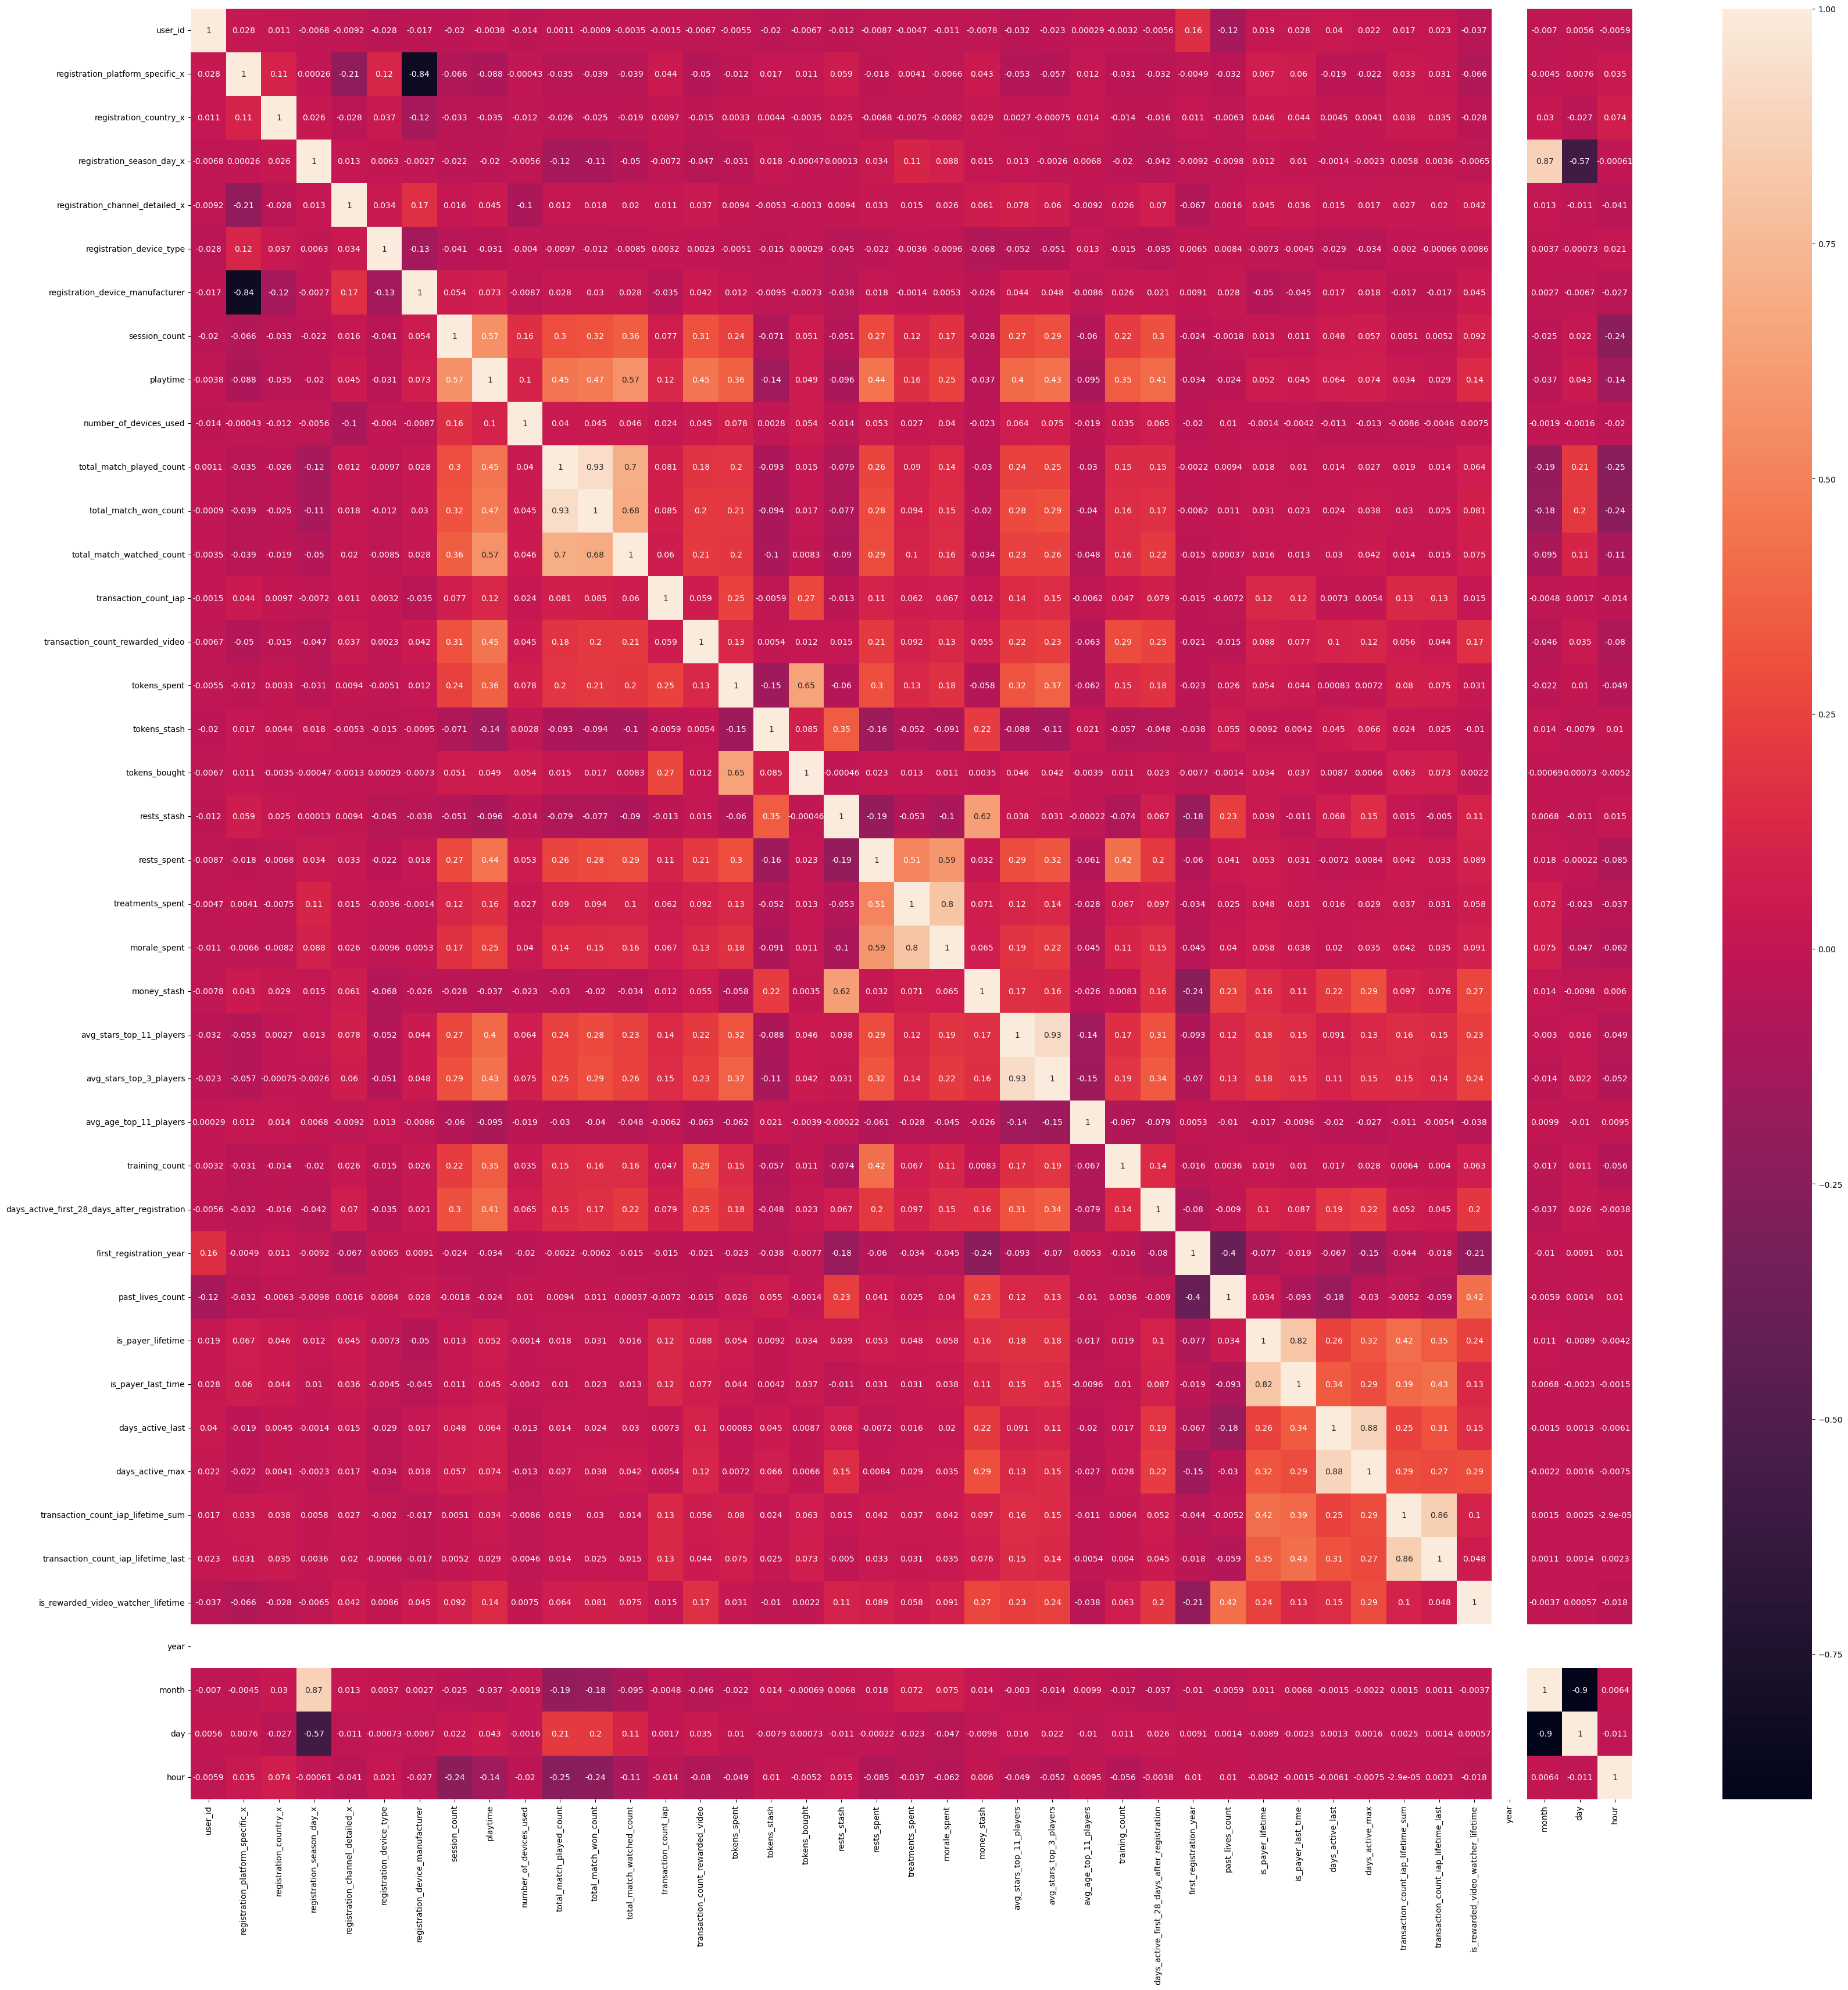

In [37]:
fig = plt.figure(figsize=(40, 40))
sns.heatmap(df_transformed.corr(), annot=True)
fig.savefig("correlation_matrix_transformed")
plt.show()

# Experimenting with different models

Using 30% data for faster experimenting

In [38]:
df_transformed = df_transformed.sample(frac=0.3, random_state=42)

In [39]:
X, y = df_transformed.drop("days_active_first_28_days_after_registration", axis=1), df_transformed["days_active_first_28_days_after_registration"]

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

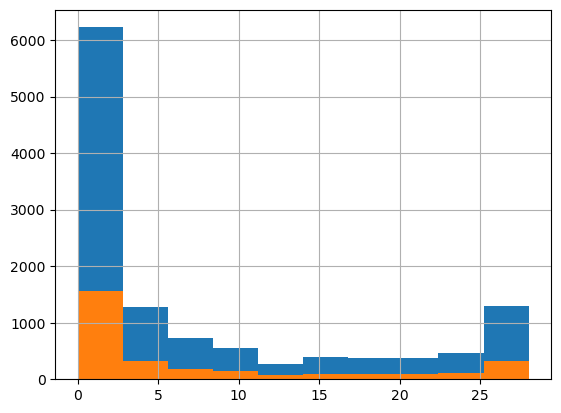

In [41]:
plt.figure()
y_train.hist()
y_val.hist()
plt.show()

In [42]:
def evaluate(model, X_val, y_val):
    y_preds = model.predict(X_val)
    y_preds = np.round(model.predict(X_val)).astype(int)
    return mean_absolute_error(y_val, y_preds)

### RandomForestRegressor (MAE = 5.5)

In [43]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = RandomizedSearchCV(RandomForestRegressor(), param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs = -1,
                   verbose=1, random_state=42)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 10}
Best score: -5.9545319758270745


In [44]:
np.mean(cross_val_score(RandomForestRegressor(n_estimators=100, min_samples_split=2, max_depth=10), X, y, cv=5, scoring="neg_mean_absolute_error"))

-5.961648210329951

In [45]:
model_abs = RandomForestRegressor(criterion='absolute_error', max_depth=10, n_estimators=100, min_samples_split=2)
np.mean(cross_val_score(model_abs, X, y, cv=5, scoring="neg_mean_absolute_error"))

-5.474193333333334

In [46]:
model_abs.fit(X_train, y_train)
y_preds = model_abs.predict(X_val)
y_preds = np.round(model_abs.predict(X_val)).astype(int)
pd.crosstab(y_val, y_preds)

col_0                                          0    1   2   3   4   5   6   \
days_active_first_28_days_after_registration                                 
0                                             673  115  61  27  30  25  19   
1                                             112   28  31  16  16  17  17   
2                                              51   16  13   6   8  13   9   
3                                              22   12  13  11   8   8   6   
4                                              11    8   3   7   7   4   6   
5                                               9    6   6   6   4   6   3   
6                                              11    4   5   3   2   4   5   
7                                               9    6   2   5   3   3   4   
8                                               5    3   3   2   2   2   5   
9                                               3    4   6   3   1   2   2   
10                                              3    2   3   2   2   3   3   
11                                              3    0   4   0   1   2   3   
12                                              4    2   1   1   1   0   1   
13                                              1    0   3   0   2   1   1   
14                                              1    1   1   2   2   3   1   
15                                              3    2   2   2   1   1   0   
16                                              3    2   2   1   1   3   1   
17                                              3    2   4   0   0   2   1   
18                                              2    1   1   0   1   0   3   
19                                              4    1   3   0   1   1   0   
20                                              1    0   2   0   2   3   2   
21                                              1    2   1   1   1   3   0   
22                                              1    1   1   1   2   3   3   
23                                              2    2   2   1   2   2   0   
24                                              1    0   0   1   1   0   2   
25                                              4    0   0   1   1   0   2   
26                                              3    1   2   1   3   2   3   
27                                              5    3   3   3   5   6   3   
28                                              4    4   3   3   2   9   5   

col_0                                         7   8   9   ...  15  16  17  18  \
days_active_first_28_days_after_registration              ...                   
0                                             17  17  12  ...   4   3   0   1   
1                                             10  13  10  ...   6   5   6   3   
2                                              6   7   4  ...   5   2   3   0   
3                                              9   6   6  ...   2   2   1   2   
4                                              8   5   4  ...   3   3   5   3   
5                                              1   4   7  ...   3   4   2   0   
6                                              4   4   2  ...   5   7   3   0   
7                                              6   0   3  ...   4   0   1   0   
8                                              2   2   4  ...   1   1   2   1   
9                                              2   3   1  ...   2   2   1   0   
10                                             4   1   3  ...   5   0   1   1   
11                                             3   2   2  ...   3   0   0   1   
12                                             6   0   7  ...   1   1   2   1   
13                                             1   2   4  ...   3   0   1   0   
14                                             1   1   3  ...   3   3   0   0   
15                                             1   0   2  ...   2   3   2   0   
16                                             1   0   3  ...   0   3   3   1   
17                                        

### RandomForestClassifier + RandomForestRegressor (MAE = 5.428)

In [47]:
y_classification = y_train.copy()
y_classification[(y_classification > 2) & (y_classification < 27)] = 15

clf = RandomForestClassifier()

clf.fit(X_train, y_classification)
y_clf_preds = clf.predict(X_val)

y_reg_preds = model_abs.predict(X_val)

y_preds = np.where(y_clf_preds!=15, y_clf_preds, y_reg_preds)

y_preds = np.round(y_preds).astype(int)

mean_absolute_error(y_val, y_preds)

5.4783333333333335

### XGBRegressor (MAE = 5.75)

In [48]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.2, 0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

xgb_model = XGBRegressor()

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1}
Best score:  -5.851844409607516


### CatBoostRegressor(MAE = 5.31)

In [49]:
cat = CatBoostRegressor(loss_function='MAE') 
np.mean(cross_val_score(cat, X, y, cv=5, scoring="neg_mean_absolute_error"))

0:	learn: 6.9828482	total: 144ms	remaining: 2m 23s
1:	learn: 6.9036985	total: 148ms	remaining: 1m 13s
2:	learn: 6.8305165	total: 151ms	remaining: 50.3s
3:	learn: 6.7620618	total: 155ms	remaining: 38.6s
4:	learn: 6.6931182	total: 158ms	remaining: 31.5s
5:	learn: 6.6318745	total: 162ms	remaining: 26.8s
6:	learn: 6.5742405	total: 164ms	remaining: 23.3s
7:	learn: 6.5174382	total: 168ms	remaining: 20.8s
8:	learn: 6.4689901	total: 170ms	remaining: 18.8s
9:	learn: 6.4222209	total: 173ms	remaining: 17.1s
10:	learn: 6.3790207	total: 176ms	remaining: 15.8s
11:	learn: 6.3304954	total: 179ms	remaining: 14.7s
12:	learn: 6.2850981	total: 181ms	remaining: 13.8s
13:	learn: 6.2440366	total: 184ms	remaining: 13s
14:	learn: 6.2061291	total: 187ms	remaining: 12.3s
15:	learn: 6.1688660	total: 190ms	remaining: 11.7s
16:	learn: 6.1399062	total: 192ms	remaining: 11.1s
17:	learn: 6.1089881	total: 195ms	remaining: 10.6s
18:	learn: 6.0851043	total: 198ms	remaining: 10.2s
19:	learn: 6.0554977	total: 201ms	remaini

-5.337098385747309

# Trying to improve the best performing model - CatBoostRegressor

In [50]:
cat = CatBoostRegressor(loss_function='MAE') 
cat.fit(X_train, y_train)
evaluate(cat, X_val, y_val)

0:	learn: 6.9924840	total: 3.63ms	remaining: 3.62s
1:	learn: 6.9140035	total: 6.65ms	remaining: 3.32s
2:	learn: 6.8359172	total: 9.45ms	remaining: 3.14s
3:	learn: 6.7669899	total: 12.4ms	remaining: 3.08s
4:	learn: 6.7015199	total: 15.3ms	remaining: 3.04s
5:	learn: 6.6392642	total: 18.1ms	remaining: 2.99s
6:	learn: 6.5829205	total: 20.8ms	remaining: 2.95s
7:	learn: 6.5242744	total: 23.5ms	remaining: 2.92s
8:	learn: 6.4678701	total: 26.3ms	remaining: 2.9s
9:	learn: 6.4166858	total: 29ms	remaining: 2.87s
10:	learn: 6.3733637	total: 31.7ms	remaining: 2.85s
11:	learn: 6.3273916	total: 34.5ms	remaining: 2.84s
12:	learn: 6.2841804	total: 37.2ms	remaining: 2.82s
13:	learn: 6.2418621	total: 39.9ms	remaining: 2.81s
14:	learn: 6.2045070	total: 42.8ms	remaining: 2.81s
15:	learn: 6.1665662	total: 45.7ms	remaining: 2.81s
16:	learn: 6.1327323	total: 48.6ms	remaining: 2.81s
17:	learn: 6.1002931	total: 51.4ms	remaining: 2.81s
18:	learn: 6.0750531	total: 54.3ms	remaining: 2.8s
19:	learn: 6.0452530	total

5.401666666666666

In [51]:
cat = CatBoostRegressor(loss_function='MAE') 
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [500, 1000, 1500],
    'l2_leaf_reg': [3, 5, 7],
}

grid_search = RandomizedSearchCV(cat, param_grid, n_iter=5, cv=2, scoring='neg_mean_absolute_error', n_jobs = -1,
                   verbose=1, random_state=42)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
0:	learn: 7.0488273	total: 3.77ms	remaining: 5.64s
1:	learn: 7.0221839	total: 6.99ms	remaining: 5.23s
2:	learn: 6.9943262	total: 9.99ms	remaining: 4.98s
3:	learn: 6.9679734	total: 13.1ms	remaining: 4.9s
4:	learn: 6.9398742	total: 16.1ms	remaining: 4.8s
5:	learn: 6.9152664	total: 18.9ms	remaining: 4.71s
6:	learn: 6.8914023	total: 21.6ms	remaining: 4.62s
7:	learn: 6.8654540	total: 24.5ms	remaining: 4.57s
8:	learn: 6.8433968	total: 27.5ms	remaining: 4.56s
9:	learn: 6.8204967	total: 30.3ms	remaining: 4.52s
10:	learn: 6.7984717	total: 33.3ms	remaining: 4.5s
11:	learn: 6.7736396	total: 36ms	remaining: 4.47s
12:	learn: 6.7518538	total: 38.8ms	remaining: 4.43s
13:	learn: 6.7291015	total: 41.5ms	remaining: 4.4s
14:	learn: 6.7069539	total: 44.2ms	remaining: 4.38s
15:	learn: 6.6849415	total: 47.1ms	remaining: 4.36s
16:	learn: 6.6626982	total: 49.7ms	remaining: 4.34s
17:	learn: 6.6424450	total: 52.5ms	remaining: 4.32s
18:	learn: 6.6223657

In [52]:
cat = CatBoostRegressor(loss_function='MAE',  learning_rate=0.05,
    l2_leaf_reg=7,
    iterations=500,
    depth=6)
np.mean(cross_val_score(cat, X, y, cv=5, scoring="neg_mean_absolute_error"))

0:	learn: 6.9331365	total: 3.35ms	remaining: 1.67s
1:	learn: 6.8087315	total: 6.86ms	remaining: 1.71s
2:	learn: 6.6973202	total: 9.95ms	remaining: 1.65s
3:	learn: 6.5952368	total: 12.7ms	remaining: 1.58s
4:	learn: 6.4975333	total: 15.7ms	remaining: 1.55s
5:	learn: 6.4157869	total: 18.4ms	remaining: 1.51s
6:	learn: 6.3335393	total: 21.2ms	remaining: 1.49s
7:	learn: 6.2626637	total: 24ms	remaining: 1.47s
8:	learn: 6.2033952	total: 26.9ms	remaining: 1.47s
9:	learn: 6.1557223	total: 29.4ms	remaining: 1.44s
10:	learn: 6.1073653	total: 32ms	remaining: 1.42s
11:	learn: 6.0546602	total: 34.7ms	remaining: 1.41s
12:	learn: 6.0024777	total: 37.5ms	remaining: 1.4s
13:	learn: 5.9692457	total: 40.4ms	remaining: 1.4s
14:	learn: 5.9283281	total: 43.2ms	remaining: 1.4s
15:	learn: 5.8955328	total: 46.1ms	remaining: 1.39s
16:	learn: 5.8676482	total: 48.8ms	remaining: 1.39s
17:	learn: 5.8381738	total: 51.6ms	remaining: 1.38s
18:	learn: 5.8158655	total: 54.5ms	remaining: 1.38s
19:	learn: 5.7865390	total: 5

-5.349336442769018

# Fitting and evaluating CatBoostRegressor on full dataset

In [59]:
cat = CatBoostRegressor(loss_function='MAE') 
df_transformed = combined_transformed[combined_transformed["days_active_first_28_days_after_registration"]!=-1]
df_sampled = df_transformed.sample(frac=1)
X, y = df_sampled.drop("days_active_first_28_days_after_registration", axis=1), df_sampled["days_active_first_28_days_after_registration"]
scores = cross_val_score(cat, X, y, cv=5, scoring="neg_mean_absolute_error")
scores

0:	learn: 6.9804220	total: 7.1ms	remaining: 7.1s
1:	learn: 6.9021424	total: 13.7ms	remaining: 6.85s
2:	learn: 6.8246037	total: 22.4ms	remaining: 7.44s
3:	learn: 6.7575098	total: 28.8ms	remaining: 7.16s
4:	learn: 6.6891886	total: 35.1ms	remaining: 6.98s
5:	learn: 6.6306056	total: 40.8ms	remaining: 6.76s
6:	learn: 6.5707995	total: 46.8ms	remaining: 6.63s
7:	learn: 6.5146250	total: 52.8ms	remaining: 6.55s
8:	learn: 6.4633113	total: 58.8ms	remaining: 6.48s
9:	learn: 6.4213197	total: 64.6ms	remaining: 6.39s
10:	learn: 6.3744731	total: 70.6ms	remaining: 6.35s
11:	learn: 6.3256375	total: 76.5ms	remaining: 6.3s
12:	learn: 6.2852321	total: 82.8ms	remaining: 6.29s
13:	learn: 6.2453917	total: 88.7ms	remaining: 6.24s
14:	learn: 6.2066872	total: 95ms	remaining: 6.24s
15:	learn: 6.1707364	total: 101ms	remaining: 6.21s
16:	learn: 6.1372067	total: 107ms	remaining: 6.18s
17:	learn: 6.1038331	total: 113ms	remaining: 6.18s
18:	learn: 6.0728581	total: 119ms	remaining: 6.17s
19:	learn: 6.0411745	total: 125

array([-5.2904065 , -5.29413691, -5.28412493, -5.12041952, -5.33205779])

In [60]:
np.mean(scores)

-5.264229131783651

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)
cat.fit(X_train, y_train)
evaluate(cat, X_val, y_val)

0:	learn: 6.9856565	total: 9.38ms	remaining: 9.37s
1:	learn: 6.9073827	total: 17.7ms	remaining: 8.85s
2:	learn: 6.8310259	total: 24.2ms	remaining: 8.03s
3:	learn: 6.7610662	total: 30.5ms	remaining: 7.6s
4:	learn: 6.6914416	total: 37.1ms	remaining: 7.39s
5:	learn: 6.6313926	total: 43ms	remaining: 7.13s
6:	learn: 6.5717276	total: 48.9ms	remaining: 6.94s
7:	learn: 6.5158367	total: 55.2ms	remaining: 6.84s
8:	learn: 6.4678191	total: 62ms	remaining: 6.83s
9:	learn: 6.4200460	total: 68.1ms	remaining: 6.75s
10:	learn: 6.3736707	total: 78.2ms	remaining: 7.03s
11:	learn: 6.3256436	total: 90.1ms	remaining: 7.41s
12:	learn: 6.2838749	total: 96.4ms	remaining: 7.32s
13:	learn: 6.2444056	total: 102ms	remaining: 7.2s
14:	learn: 6.2062129	total: 109ms	remaining: 7.13s
15:	learn: 6.1705826	total: 115ms	remaining: 7.05s
16:	learn: 6.1402690	total: 121ms	remaining: 7s
17:	learn: 6.1060902	total: 128ms	remaining: 6.96s
18:	learn: 6.0738656	total: 134ms	remaining: 6.9s
19:	learn: 6.0427614	total: 140ms	rema

5.2266

# Predicting on the test data and exporting final results

In [65]:
predictions = np.round(cat.predict(df_test_transformed)).astype(int)
predictions

array([ 9, 19,  2, ...,  7,  2,  0])

In [66]:
predictions.shape

(50000,)

In [68]:
result = pd.DataFrame({"user_id":df_test_transformed.user_id, "predicted_days_active_first_28_days_after_registration":predictions})
result

user_id  predicted_days_active_first_28_days_after_registration
0       300004                                                  9     
1       300006                                                 19     
2       300012                                                  2     
3       300022                                                  2     
4       300031                                                 11     
...        ...                                                ...     
49995   512688                                                 15     
49996   512690                                                 15     
49997   512702                                                  7     
49998   512712                                                  2     
49999   512713                                                  0     

[50000 rows x 2 columns]

In [71]:
result.to_csv("days_active_first_28_days_after_registration_predictions", index=False)